In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    
    def policy_fn(observation):
        return np.ones(nA) / nA
    
    return policy_fn

In [18]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        
        A = np.array([0] * len(Q[observation]))
        
        # Create action-value if not exist in Q
        if observation not in Q:
            Q[observation] = np.zeros(env.action_space.n)
            C[observation] = np.zeros(env.action_space.n)
        
        # Allow greedy action to be taken with a probability of 1
        A[np.argmax(Q[observation])] += 1
        
        return A
    
    return policy_fn

In [19]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, gamma=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function and
    # C from importance sampling formula
    Q, C = {}, {}

    # Our greedy policy that we want to learn
    target_policy = create_greedy_policy(Q)
       
    for episode in range(num_episodes):
        
        # env.reset() resets the env by dealing new cards and returns the
        # starting state (sum of hand, one dealer card, usable ace) as a tupe.
        St = env.reset()
        seq_all, terminate = [], False
        
        # Instantiate return and weight of returns (ratio)
        G, W = 0, 1
        
        # Iterate through episode until termination
        while not terminate:
        
            p = behavior_policy(St)
            At = np.random.choice(np.arange(len(p)), p=p)
            
            # env.step() takes action At and returns the new state
            # as a tuple, the reward for taking action At and a flag
            # that is True if we end up in the terminal state. For some
            # reason, step() also returns an empty dict that we ignore.
            St_new, Rt, terminate, _ = env.step(At)
            
            # Append state, action and given reward to sequence and
            # move to the new state after taking action At.
            seq_all.append((St, At, Rt))
            St = St_new
            
        # Now that we have terminated we update the average return
        # of all state-action pairs that we took during this particular episode.
        for t in range(len(seq_all)-1, 0, -1):
            
            # Get state, action and reward of step t
            s, a, r = seq_all[t]
            
            # Create key in dict if not exist
            if s not in C:
                C[s] = np.zeros(env.action_space.n)
                Q[s] = np.zeros(env.action_space.n)
            
            # Update return and weight
            G = r + gamma * G
            C[s][a] += W
            
            # Update action-value function estimation for pair.
            # This time, we have to do it incrementally.
            Q[s][a] += (W / C[s][a]) * (G - Q[s][a])
            
            # If action taken by behavior policy is not the greedy action, break
            if a != np.argmax(target_policy(s)):
                break
    
            # Otherwise update weight based on action taken
            W = W * 1./behavior_policy(s)[a]
    
    return Q, target_policy

In [22]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=5000000, behavior_policy=random_policy)

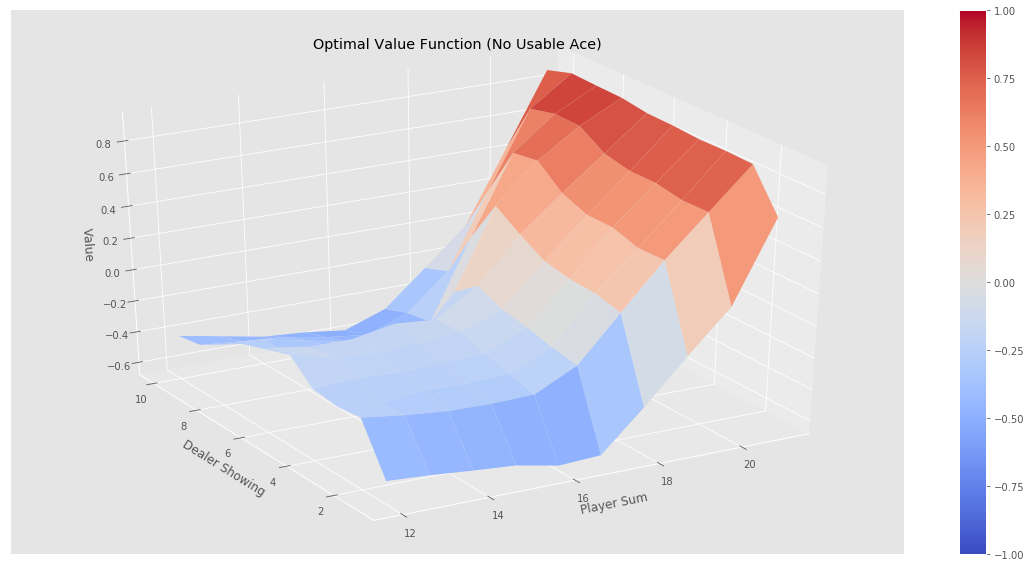

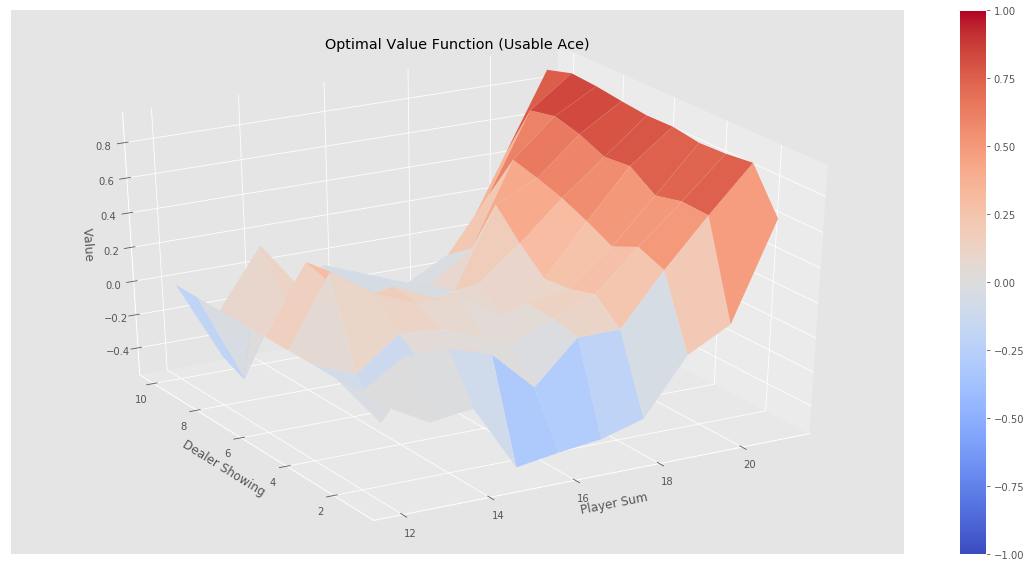

In [23]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")